# Notebook 03 — Funding-Rate & Basis Arbitrage Analysis

This notebook models a **delta-neutral carry trade** in a simplified perpetual-futures market:

| Leg | Instrument | Direction |
|-----|-----------|-----------|
| Long | Spot (proxied by simulation mid) | +1 |
| Short | Synthetic perpetual future | −1 |

The delta-neutral combination eliminates directional price exposure, leaving two P&L sources:

1. **Funding carry** — the annualised basis accrues as income while the position is open.
2. **Basis convergence** — if the perp premium widens/tightens, the spread P&L adjusts the carry.

**Sections**
| # | Topic |
|---|-------|
| 1 | Synthetic basis construction (Ornstein-Uhlenbeck process) |
| 2 | Threshold-based entry/exit strategy |
| 3 | P&L decomposition: carry vs. basis convergence vs. transaction cost |
| 4 | Entry-threshold sensitivity sweep |

> **Scope:** This is a stylised interview-level model, not a production backtest.  
> Production would require real funding-interval data, borrow costs, transfer latency, and partial-fill modelling.

## How to use this notebook

1. Ensure `outputs/baseline_mm_result.json` exists — run from the repo root:
   ```bash
   make report
   # or manually:
   PYTHONPATH=src python scripts/run_backtest.py \
       --config configs/baseline_mm.json \
       --output outputs/baseline_mm_result.json
   ```
2. **Run All Cells** top-to-bottom.
3. Tweak the parameters cell below to explore different carry regimes.

### Papermill parameterisation
```bash
papermill notebooks/03_funding_basis_arb_analysis.ipynb outputs/nb03_run.ipynb \
    -p result_json ../outputs/baseline_mm_result.json \
    -p entry_threshold 0.08 \
    -p exit_threshold 0.02
```

In [1]:
# ── Parameters (papermill injection point) ───────────────────────────────────
result_json      = '../outputs/baseline_mm_result.json'

# Basis-process parameters
OU_KAPPA         = 12.0    # mean-reversion speed (higher → faster reversion)
OU_VOL           = 0.25    # annualised basis volatility
OU_START         = 0.08    # initial annualised basis (8%)
BASIS_CAP        = 0.30    # hard floor/ceiling on basis (±30%)
RANDOM_SEED      = 11

# Strategy parameters
entry_threshold  = 0.05    # open carry trade when annualised basis >= this
exit_threshold   = 0.01    # close carry trade when annualised basis <= this
notional_usd     = 10_000.0
fee_bps_per_leg  = 2.0     # one-way taker fee on each leg

# Sensitivity sweep range
SWEEP_THRESHOLDS = [0.02, 0.03, 0.05, 0.08, 0.12, 0.18, 0.25]

In [2]:
from __future__ import annotations

import json
import math
import random
from pathlib import Path

import matplotlib.pyplot as plt

result_path = Path(result_json)
if not result_path.exists():
    raise FileNotFoundError(
        f'Missing {result_json}. Run `make report` first.'
    )

with result_path.open('r', encoding='utf-8') as f:
    payload = json.load(f)

spot = payload['series']['mid']   # use simulation mid as spot proxy
n    = len(spot)
dt   = 1.0 / (365.0 * 24.0 * 60.0)  # 1 step ≈ 1 calendar minute

print(f'Loaded {n} steps of spot data.')
print(f'Spot range: [{min(spot):.4f}, {max(spot):.4f}]')

Loaded 2500 steps of spot data.
Spot range: [98.7741, 103.6661]


## 1) Synthetic basis construction

### The Ornstein-Uhlenbeck (OU) process

Real perpetual-futures basis does not wander arbitrarily far from zero — it is anchored by:
- Funding payments that reset every 8 hours (on most venues), and
- Arbitrageurs who enter/exit the carry trade when basis becomes extreme.

An **Ornstein-Uhlenbeck** process captures this mean-reverting behaviour:

```
dB(t) = −κ · B(t) · dt + σ · dW(t)
```

| Parameter | Symbol | Role |
|-----------|--------|------|
| Mean-reversion speed | `κ` (`OU_KAPPA`) | How quickly basis snaps back to zero. κ=12 means expected half-life ≈ ln(2)/12 ≈ 0.058 years ≈ 3 weeks |
| Volatility | `σ` (`OU_VOL`) | Magnitude of random shocks to the basis |
| Floor/ceiling | `BASIS_CAP` | Hard cap at ±30% to stay in realistic range |

### Synthetic perpetual price

The perp mid is constructed as:

```
perp(t) = spot(t) × (1 + B(t) / (365 × 24))
```

This approximates one minute of funding accrual at the current annualised rate — the perp trades at a premium (positive basis) or discount (negative basis) to spot.

Basis  mean: 8.683%   std: 0.354%
Steps with basis ≥ entry threshold (5%): 100.0%


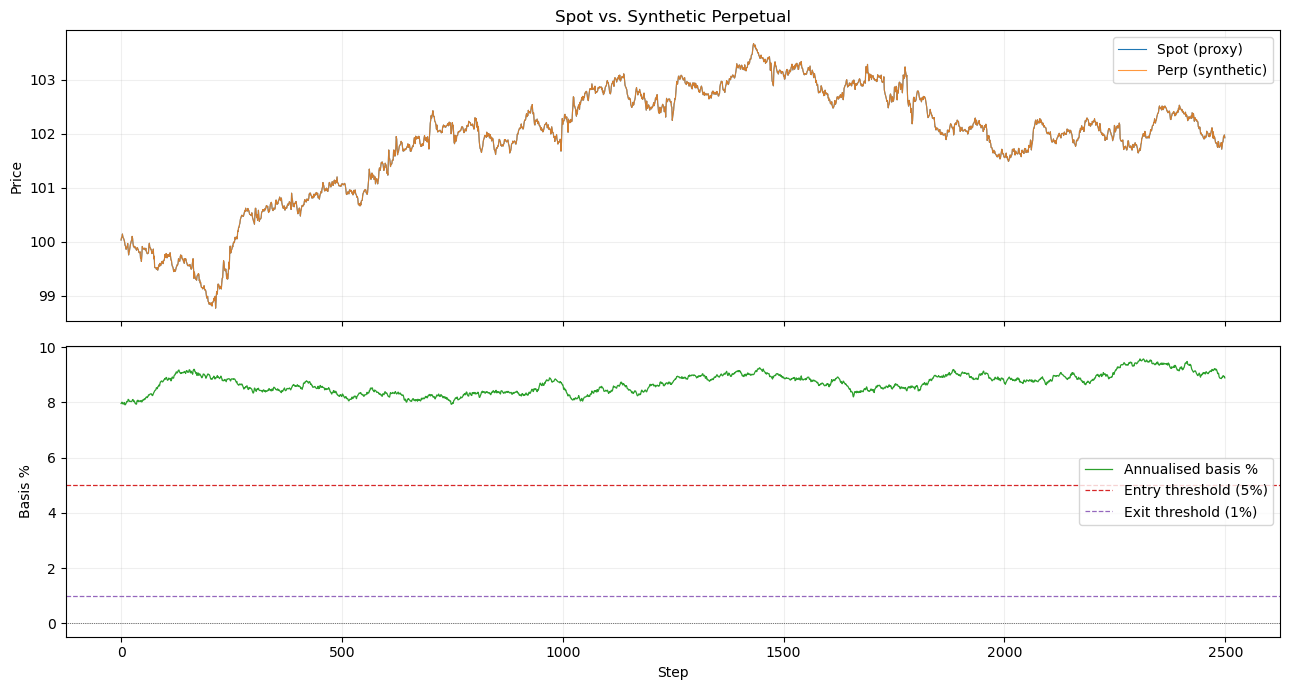

In [3]:
rng = random.Random(RANDOM_SEED)
basis = []
b = OU_START
for _ in range(n):
    shock = rng.gauss(0.0, OU_VOL * math.sqrt(dt))
    b += -OU_KAPPA * b * dt + shock
    b = max(-BASIS_CAP, min(BASIS_CAP, b))
    basis.append(b)

perp = [s * (1.0 + b_ / (365.0 * 24.0)) for s, b_ in zip(spot, basis)]

# Summary statistics for the basis process
avg_basis = sum(basis) / len(basis)
std_basis = math.sqrt(sum((x - avg_basis)**2 for x in basis) / len(basis))
pct_rich   = sum(1 for x in basis if x >= entry_threshold) / n * 100
print(f'Basis  mean: {avg_basis*100:.3f}%   std: {std_basis*100:.3f}%')
print(f'Steps with basis ≥ entry threshold ({entry_threshold*100:.0f}%): {pct_rich:.1f}%')

fig, ax = plt.subplots(2, 1, figsize=(13, 7), sharex=True)
ax[0].plot(spot, label='Spot (proxy)', color='tab:blue', lw=0.8)
ax[0].plot(perp, label='Perp (synthetic)', color='tab:orange', lw=0.8, alpha=0.8)
ax[0].set_ylabel('Price')
ax[0].legend()
ax[0].grid(alpha=0.2)
ax[0].set_title('Spot vs. Synthetic Perpetual')

ax[1].plot([100.0 * x for x in basis], label='Annualised basis %',
           color='tab:green', lw=0.9)
ax[1].axhline(entry_threshold * 100, color='tab:red', linestyle='--',
              lw=0.9, label=f'Entry threshold ({entry_threshold*100:.0f}%)')
ax[1].axhline(exit_threshold * 100, color='tab:purple', linestyle='--',
              lw=0.9, label=f'Exit threshold ({exit_threshold*100:.0f}%)')
ax[1].axhline(0.0, color='black', lw=0.5, linestyle=':')
ax[1].set_ylabel('Basis %')
ax[1].set_xlabel('Step')
ax[1].legend()
ax[1].grid(alpha=0.2)

plt.tight_layout()
plt.show()

## 2) Carry-trade strategy logic

### Entry and exit rules

The strategy is purely threshold-based — no forecasting, no machine learning:

| Condition | Action |
|-----------|--------|
| `basis ≥ entry_threshold` and flat | **Enter**: buy `qty` spot, short `qty` perp |
| `basis ≤ exit_threshold` and in trade | **Exit**: sell `qty` spot, cover `qty` perp |

The entry `qty` is sized to a fixed USD notional:
```python
qty = notional_usd / spot_price_at_entry
```

### Why delta-neutral?

Holding long spot and short perp of the same `qty` creates a portfolio where:
- A price move of +$1 in spot gives +`qty` P&L on the long leg.
- The same +$1 move gives approximately −`qty` P&L on the short perp leg.
- Net directional exposure ≈ **zero** (delta-neutral).

What remains is the **basis P&L**: if the perp premium widens while we are in the trade, our short perp loses more than our long spot gains, and vice versa. The funding carry accrues continuously on the short perp leg.

### Transaction costs

Each entry or exit is two-leg (spot + perp), so total transaction cost per round-trip is:
```
cost = 2 × qty × price × (fee_bps / 10_000)
```
With `fee_bps_per_leg = 2`, this is 4 bps per round-trip — a realistic taker-fee assumption for crypto venues.

In [4]:
position    = 0        # 0 = flat, 1 = in carry trade
qty         = 0.0
total_cost  = 0.0
carry_pnl   = 0.0
basis_pnl   = 0.0
trades      = 0
wins        = 0

equity      = []
inv_state   = []
carry_path  = []
basis_path  = []
cost_path   = []

for t in range(1, n):
    s0, s1 = spot[t - 1], spot[t]
    p0, p1 = perp[t - 1], perp[t]
    b0     = basis[t - 1]

    # ── Entry ──────────────────────────────────────────────────────────────
    if position == 0 and b0 >= entry_threshold:
        qty           = notional_usd / max(s0, 1e-9)
        round_notional = qty * s0 + qty * p0
        cost          = round_notional * (fee_bps_per_leg / 10_000.0)
        total_cost   += cost
        trades       += 1
        position      = 1

    # ── Exit ───────────────────────────────────────────────────────────────
    elif position == 1 and b0 <= exit_threshold:
        round_notional = qty * s0 + qty * p0
        cost          = round_notional * (fee_bps_per_leg / 10_000.0)
        total_cost   += cost
        trades       += 1
        # check if this round-trip was profitable
        rtrip_pnl = carry_pnl + basis_pnl - total_cost
        if rtrip_pnl > 0:
            wins += 1
        position = 0
        qty      = 0.0

    # ── P&L attribution while in trade ─────────────────────────────────────
    step_carry = 0.0
    step_basis = 0.0
    if position == 1:
        # Funding carry: accrues at annualised rate B, scaled to one step
        step_carry  = notional_usd * b0 * dt

        # Basis convergence: short perp, long spot — gain from spread tightening
        spread0     = p0 - s0
        spread1     = p1 - s1
        step_basis  = -qty * (spread1 - spread0)

    carry_pnl += step_carry
    basis_pnl += step_basis

    eq = carry_pnl + basis_pnl - total_cost
    equity.append(eq)
    inv_state.append(position)
    carry_path.append(carry_pnl)
    basis_path.append(basis_pnl)
    cost_path.append(total_cost)

# ── Summary ────────────────────────────────────────────────────────────────
final_pnl       = equity[-1] if equity else 0.0
exposure_ratio  = sum(inv_state) / len(inv_state) if inv_state else 0.0
pnl_per_trade   = final_pnl / trades if trades else 0.0

print('=== Carry Strategy Summary ===')
print(f'  trades                 : {trades}')
print(f'  time_in_trade          : {exposure_ratio*100:.1f}%')
print(f'  carry_pnl              : {carry_pnl:+.4f}')
print(f'  basis_convergence_pnl  : {basis_pnl:+.4f}')
print(f'  transaction_cost       : {total_cost:.4f}')
print(f'  final_pnl              : {final_pnl:+.4f}')
print(f'  pnl_per_trade          : {pnl_per_trade:+.4f}')

=== Carry Strategy Summary ===
  trades                 : 1
  time_in_trade          : 100.0%
  carry_pnl              : +4.1281
  basis_convergence_pnl  : -0.0125
  transaction_cost       : 4.0000
  final_pnl              : +0.1156
  pnl_per_trade          : +0.1156


## 3) P&L decomposition and exposure

### What the decomposition reveals

The three components sum to total P&L:

```
Total P&L = Carry income + Basis convergence P&L − Transaction costs
```

Interpreting each component:

| Component | Positive sign means | Warning sign |
|-----------|-------------------|--------------|
| **Carry income** | Funding accrued while in the trade | Small → entry threshold too high; rarely entered |
| **Basis convergence** | Perp premium tightened after entry (good for short perp) | Large negative → entered at a local peak; basis kept widening |
| **Transaction costs** | Always negative — drag on P&L | Dominates → threshold too low; too many small trades |

The strategy is profitable when carry income > |basis_pnl losses| + transaction_cost. If transaction costs dominate, raise `entry_threshold` to reduce trade frequency.

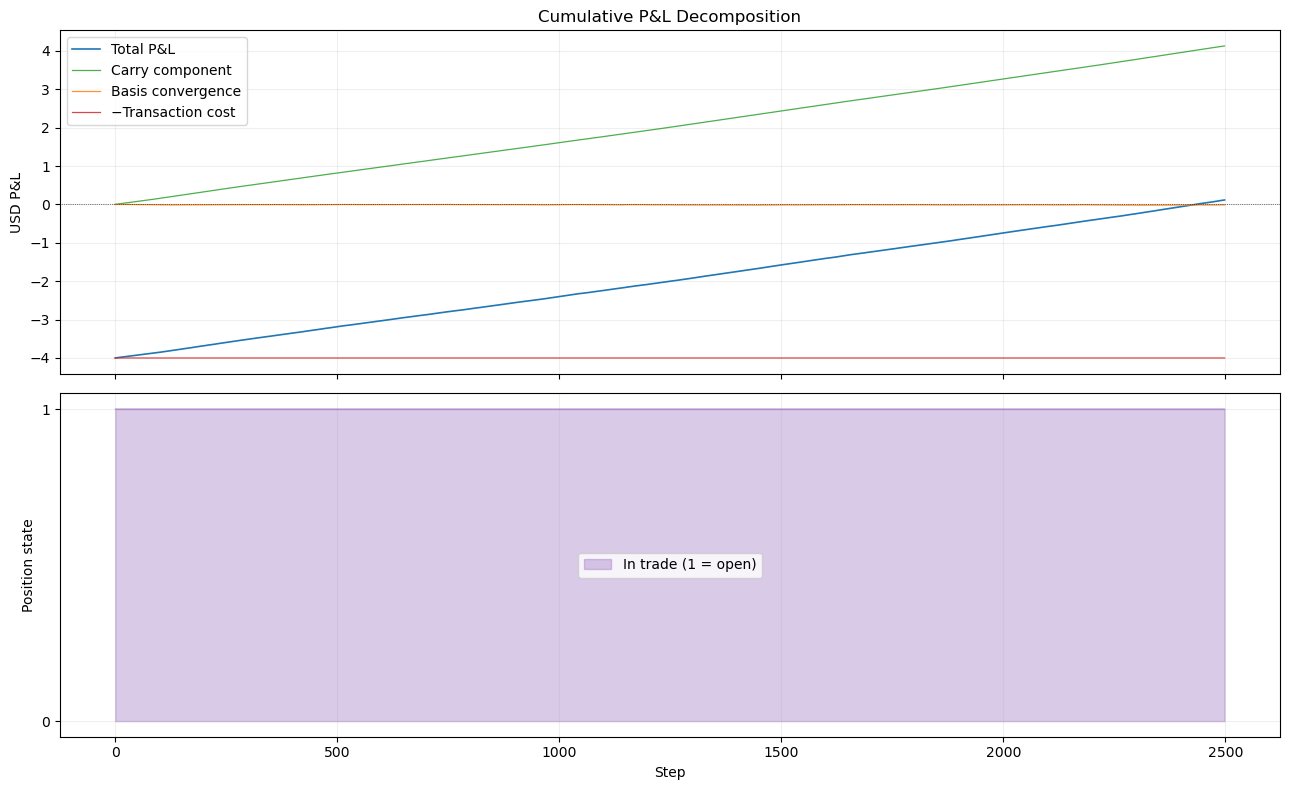

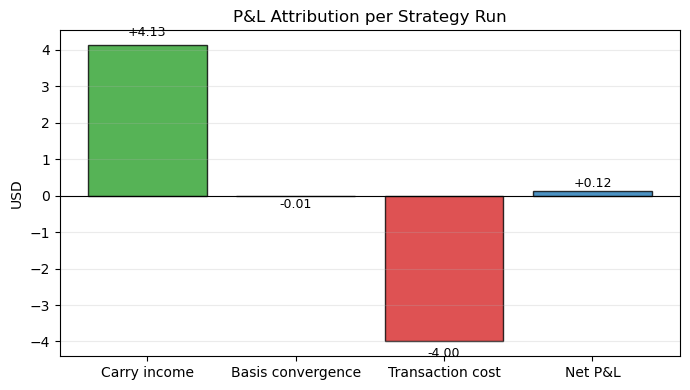

In [5]:
x = list(range(len(equity)))

fig, axes = plt.subplots(2, 1, figsize=(13, 8), sharex=True)

axes[0].plot(x, equity,         label='Total P&L',              color='tab:blue',   lw=1.2)
axes[0].plot(x, carry_path,     label='Carry component',         color='tab:green',  lw=0.9, alpha=0.85)
axes[0].plot(x, basis_path,     label='Basis convergence',       color='tab:orange', lw=0.9, alpha=0.85)
axes[0].plot(x, [-c for c in cost_path], label='−Transaction cost', color='tab:red', lw=0.9, alpha=0.85)
axes[0].axhline(0, color='black', lw=0.5, linestyle=':')
axes[0].set_ylabel('USD P&L')
axes[0].legend(loc='upper left')
axes[0].grid(alpha=0.2)
axes[0].set_title('Cumulative P&L Decomposition')

axes[1].fill_between(x, inv_state, alpha=0.35, color='tab:purple', label='In trade (1 = open)')
axes[1].plot(x, inv_state, color='tab:purple', lw=0.6)
axes[1].set_ylabel('Position state')
axes[1].set_xlabel('Step')
axes[1].set_yticks([0, 1])
axes[1].legend()
axes[1].grid(alpha=0.2)

plt.tight_layout()
plt.show()

# Attribution bar chart
fig2, ax2 = plt.subplots(figsize=(7, 4))
components = ['Carry income', 'Basis convergence', 'Transaction cost', 'Net P&L']
values     = [carry_pnl, basis_pnl, -total_cost, final_pnl]
colors     = ['tab:green' if v >= 0 else 'tab:red' for v in values]
colors[-1] = 'tab:blue'
bars = ax2.bar(components, values, color=colors, edgecolor='black', alpha=0.8)
ax2.axhline(0, color='black', lw=0.8)
ax2.set_ylabel('USD')
ax2.set_title('P&L Attribution per Strategy Run')
ax2.grid(axis='y', alpha=0.25)
for bar, v in zip(bars, values):
    offset = max(abs(v) * 0.04, 0.05)
    ax2.text(bar.get_x() + bar.get_width() / 2,
             v + (offset if v >= 0 else -offset),
             f'{v:+.2f}', ha='center',
             va='bottom' if v >= 0 else 'top', fontsize=9)
plt.tight_layout()
plt.show()

## 4) Entry-threshold sensitivity sweep

### The threshold trade-off

`entry_threshold` controls how selective the strategy is:

- **Too low** (e.g. 2%): enters frequently — high carry income, but transaction costs accumulate rapidly and the basis may not have moved far enough to revert profitably.
- **Too high** (e.g. 25%): enters rarely — low transaction drag but may miss most carry opportunities entirely; basis at extreme levels may spike and worsen before reverting.

The optimal threshold balances carry capture against cost drag. The sweep below maps this trade-off empirically on the synthetic data.

   Threshold  Trades     Carry      Cost    Net PnL   Sharpe
----------------------------------------------------------
         2%        1      +4.13      -4.00       +0.12   +2862.17
         3%        1      +4.13      -4.00       +0.12   +2862.17
         5%        1      +4.13      -4.00       +0.12   +2862.17
         8%        1      +4.13      -4.00       +0.11     +0.41
        12%        0      +0.00      -0.00       +0.00     +0.00
        18%        0      +0.00      -0.00       +0.00     +0.00
        25%        0      +0.00      -0.00       +0.00     +0.00


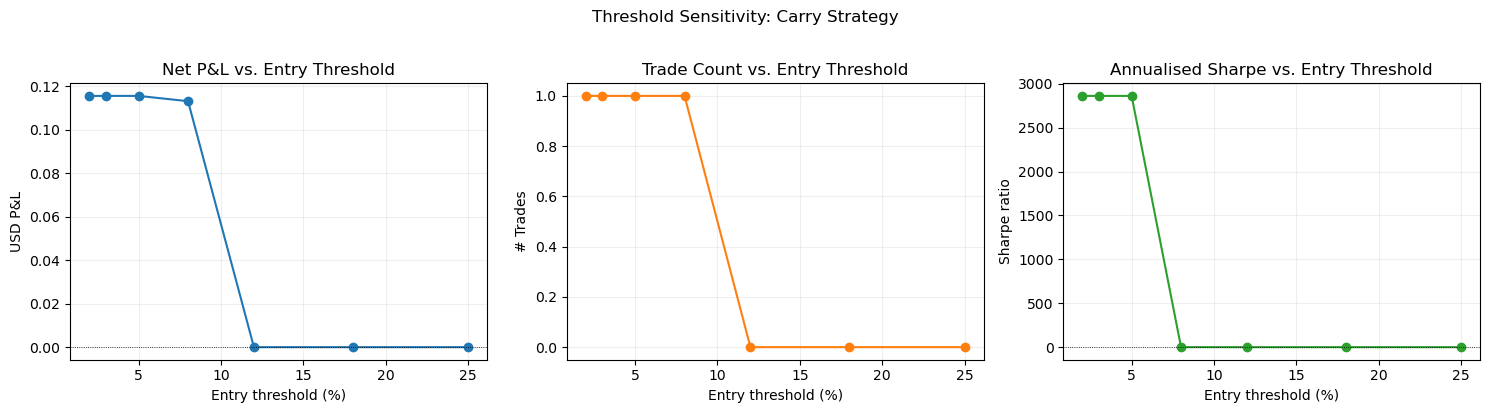

In [6]:
def run_carry(entry_thr, exit_thr=None):
    """Run the carry strategy for a given entry threshold and return summary dict."""
    if exit_thr is None:
        exit_thr = entry_thr / 5.0   # keep exit at 1/5 of entry

    pos = 0; qty_ = 0.0; tcost = 0.0; cpnl = 0.0; bpnl = 0.0; trades_ = 0
    eq_ = []
    for t in range(1, n):
        s0_, s1_ = spot[t-1], spot[t]
        p0_, p1_ = perp[t-1], perp[t]
        b0_      = basis[t-1]

        if pos == 0 and b0_ >= entry_thr:
            qty_   = notional_usd / max(s0_, 1e-9)
            tcost += (qty_*s0_ + qty_*p0_) * (fee_bps_per_leg/10_000)
            trades_ += 1; pos = 1

        elif pos == 1 and b0_ <= exit_thr:
            tcost += (qty_*s0_ + qty_*p0_) * (fee_bps_per_leg/10_000)
            trades_ += 1; pos = 0; qty_ = 0.0

        if pos == 1:
            cpnl += notional_usd * b0_ * dt
            bpnl += -qty_ * ((p1_-s1_) - (p0_-s0_))

        eq_.append(cpnl + bpnl - tcost)

    pnl_ = eq_[-1] if eq_ else 0.0
    # annualised Sharpe proxy (daily returns from step-level equity)
    if len(eq_) > 1:
        rets_ = [eq_[i]-eq_[i-1] for i in range(1, len(eq_))]
        mu_ = sum(rets_)/len(rets_)
        std_ = math.sqrt(sum((r-mu_)**2 for r in rets_)/len(rets_)) + 1e-12
        steps_per_year = 365*24*60
        sharpe_ = mu_ / std_ * math.sqrt(steps_per_year)
    else:
        sharpe_ = 0.0
    return {'pnl': pnl_, 'trades': trades_, 'sharpe': sharpe_,
            'carry': cpnl, 'cost': tcost}

results = {thr: run_carry(thr) for thr in SWEEP_THRESHOLDS}

print(f"{'Threshold':>12s} {'Trades':>7s} {'Carry':>9s} {'Cost':>9s} {'Net PnL':>10s} {'Sharpe':>8s}")
print('-' * 58)
for thr, res in results.items():
    print(f"  {thr*100:>8.0f}%   {res['trades']:>6d}   {res['carry']:>+8.2f}   "
          f"{-res['cost']:>+8.2f}   {res['pnl']:>+9.2f}   {res['sharpe']:>+7.2f}")

# Plots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
thrs = [t*100 for t in SWEEP_THRESHOLDS]

axes[0].plot(thrs, [results[t]['pnl']    for t in SWEEP_THRESHOLDS], marker='o', color='tab:blue')
axes[0].axhline(0, color='black', lw=0.6, linestyle=':')
axes[0].set_title('Net P&L vs. Entry Threshold')
axes[0].set_xlabel('Entry threshold (%)')
axes[0].set_ylabel('USD P&L')
axes[0].grid(alpha=0.2)

axes[1].plot(thrs, [results[t]['trades'] for t in SWEEP_THRESHOLDS], marker='o', color='tab:orange')
axes[1].set_title('Trade Count vs. Entry Threshold')
axes[1].set_xlabel('Entry threshold (%)')
axes[1].set_ylabel('# Trades')
axes[1].grid(alpha=0.2)

axes[2].plot(thrs, [results[t]['sharpe'] for t in SWEEP_THRESHOLDS], marker='o', color='tab:green')
axes[2].axhline(0, color='black', lw=0.6, linestyle=':')
axes[2].set_title('Annualised Sharpe vs. Entry Threshold')
axes[2].set_xlabel('Entry threshold (%)')
axes[2].set_ylabel('Sharpe ratio')
axes[2].grid(alpha=0.2)

plt.suptitle('Threshold Sensitivity: Carry Strategy', y=1.02)
plt.tight_layout()
plt.show()

## Caveats and model scope

### What this model captures
- Mean-reverting basis dynamics via an OU process with realistic parameterisation
- Delta-neutral P&L decomposition: carry vs. basis convergence vs. transaction cost
- The fundamental trade-off between entry selectivity and cost drag

### What is intentionally simplified

| Simplification | Real-world complication |
|---------------|------------------------|
| Continuous funding accrual each step | Real perps settle funding every 8 hours in discrete payments |
| Instantaneous fill on both legs | Leg risk: leg 1 fills, leg 2 may not (especially in volatile markets) |
| Fixed `fee_bps_per_leg` | Real fees depend on tier, maker/taker, and time of day |
| No borrow cost on short perp | Short selling the perp may require margin/collateral with a funding cost |
| No transfer latency between spot and perp | Moving collateral between venues takes minutes to hours |
| Single-name basis process | Real arb involves multiple venues and correlated basis processes |

### Extensions to try
- Replace OU basis with empirical funding-rate data from a crypto API
- Add a **funding-interval reset**: basis jumps at each 8-hour settlement, model this as a discrete shock
- Model **leg risk**: simulate failed fills on one leg with a probability `p_fail`
- Run a 2D sweep over both `entry_threshold` and `exit_threshold` to find the optimal exit ratio